In [2]:
import requests
import pandas as pd
from itertools import product

# URL til SSB API for tabell 03024
API_URL = "https://data.ssb.no/api/v0/no/table/03024/"

def fetch_data(api_url=API_URL):
    """Henter data fra SSB API og returnerer JSON-responsen."""
    query = {
        "query": [],
        "response": {"format": "json-stat2"}
    }
    response = requests.post(api_url, json=query)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Feil ved henting av data: {response.status_code}\n{response.text}")

def process_data(data):
    """Prosesserer JSON-data og returnerer en formatert Pandas DataFrame."""
    dimension_names = list(data["dimension"].keys())
    values = data["value"]

    # Kombinasjoner av dimensjoner
    dimensions = [list(data["dimension"][dim]["category"]["label"].values()) for dim in dimension_names]
    all_combinations = list(product(*dimensions))

    # Lag DataFrame og knytt til verdiene
    df = pd.DataFrame(all_combinations, columns=dimension_names)
    df["Value"] = values

    # Pivotér data
    df_pivot = df.pivot_table(index="Tid", columns=["VareGrupper2", "ContentsCode"], values="Value", aggfunc="sum").reset_index()
    df_pivot.columns = ["Tid", "Fersk laks - Kilospris", "Fersk laks - Vekt (tonn)", "Frosset laks - Kilospris", "Frosset laks - Vekt (tonn)"]

    # Del opp "Tid" i År og Uke
    df_pivot["År"] = df_pivot["Tid"].str[:4].astype(int)
    df_pivot["Uke"] = df_pivot["Tid"].str[5:].astype(int)
   


    # Fjern "Tid" og omorganiser kolonner slik at År og Uke kommer først
    df_pivot = df_pivot.drop(columns=["Tid"])
    kolonnerekkefølge = ["År", "Uke"] + [col for col in df_pivot.columns if col not in ["År", "Uke"]]
    df_pivot = df_pivot[kolonnerekkefølge]

    # Lag en uke-dato-kolonne for plotting (mandag i hver uke)
    df_pivot["UkeDato"] = pd.to_datetime(df_pivot["År"].astype(str) + "-" + df_pivot["Uke"].astype(str).str.zfill(2) + "-1", format="%Y-%W-%w")


    return df_pivot


def main():
    try:
        data = fetch_data()
        df_pivot = process_data(data)
        print(df_pivot.to_string(index=False))  # Valgfritt: skriv ut for å sjekke
        print("Data hentet, sortert og formatert for visning.")
        return df_pivot
    except Exception as e:
        print(e)
        return None

if __name__ == "__main__":
    main()


  År  Uke  Fersk laks - Kilospris  Fersk laks - Vekt (tonn)  Frosset laks - Kilospris  Frosset laks - Vekt (tonn)    UkeDato
2000    1                   30.98                    3728.0                     32.54                       383.0 2000-01-03
2000    2                   31.12                    4054.0                     33.63                       216.0 2000-01-10
2000    3                   31.03                    4043.0                     36.06                       633.0 2000-01-17
2000    4                   30.95                    3730.0                     34.27                       393.0 2000-01-24
2000    5                   31.30                    3831.0                     33.91                       453.0 2000-01-31
2000    6                   32.53                    4415.0                     35.30                       265.0 2000-02-07
2000    7                   32.46                    4617.0                     34.49                       344.0 2000-02-14


  År  Uke  Fersk laks - Kilospris  Fersk laks - Vekt (tonn)  Frosset laks - Kilospris  Frosset laks - Vekt (tonn)    UkeDato
2000    1                   30.98                    3728.0                     32.54                       383.0 2000-01-03
2000    2                   31.12                    4054.0                     33.63                       216.0 2000-01-10
2000    3                   31.03                    4043.0                     36.06                       633.0 2000-01-17
2000    4                   30.95                    3730.0                     34.27                       393.0 2000-01-24
2000    5                   31.30                    3831.0                     33.91                       453.0 2000-01-31
2000    6                   32.53                    4415.0                     35.30                       265.0 2000-02-07
2000    7                   32.46                    4617.0                     34.49                       344.0 2000-02-14


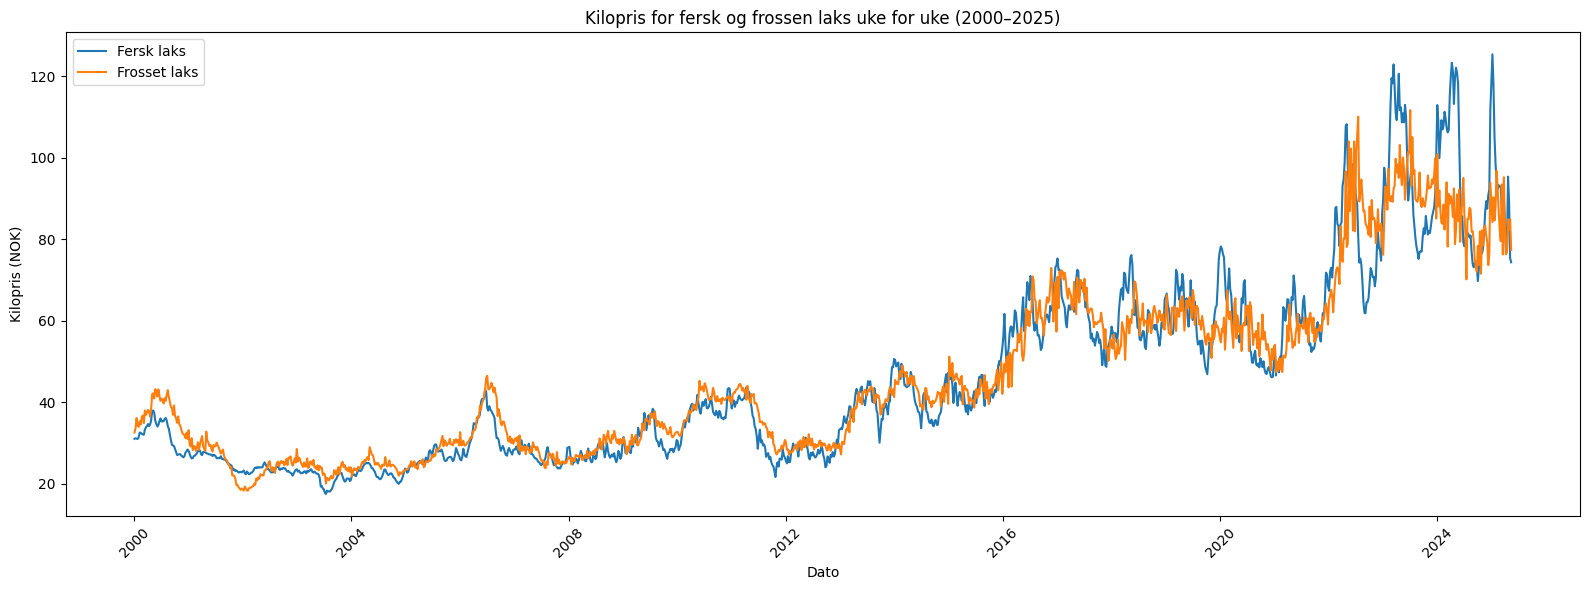

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

df = main()
if df is not None:
    plt.figure(figsize=(16, 6))
    sns.lineplot(data=df, x="UkeDato", y="Fersk laks - Kilospris", label="Fersk laks")
    sns.lineplot(data=df, x="UkeDato", y="Frosset laks - Kilospris", label="Frosset laks")
    plt.title("Kilopris for fersk og frossen laks uke for uke (2000–2025)")
    plt.xlabel("Dato")
    plt.ylabel("Kilopris (NOK)")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


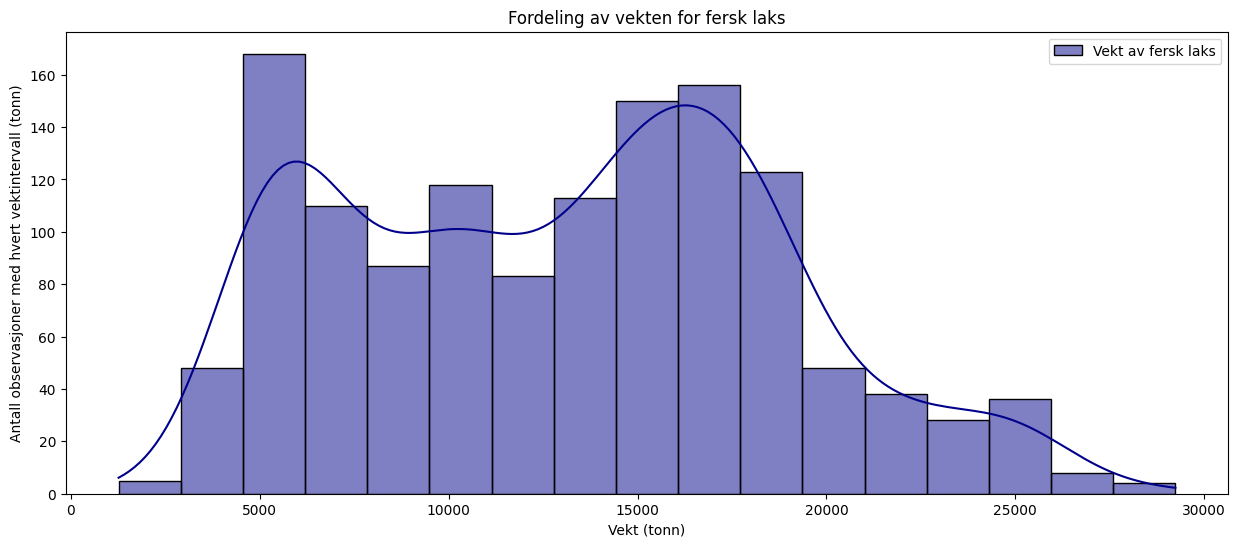

In [4]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.histplot(data=df, x = "Fersk laks - Vekt (tonn)", color = "darkblue", kde = True, label = "Vekt av fersk laks")

ax.set_title("Fordeling av vekten for fersk laks")
ax.set_xlabel("Vekt (tonn)")
ax.set_ylabel("Antall observasjoner med hvert vektintervall (tonn)")
ax.legend()


plt.show()
